# Celestial mechanics with the `celmech` code

**Sam Hadden** (CITA)

Collaborators: **Dan Tamayo** (Harvey Mudd), **David Hernandez** (Yale)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sympy import init_printing
init_printing()

# What is `celmech`?

- Code for celestial mechanics calculations
    - Calculate disturbing function expansion
    - Construct, manipulate, and integrate Hamiltonian equations of motion
    - Much more...
- Developed mainly in `python`
- Designed to work with the [`rebound`](https://github.com/hannorein/rebound) N-body code (Rein & Liu 2012)
- Symbolic mathematics with [`sympy`](https://www.sympy.org/en/index.html) (Meurer et. al. 2017)

# Where is `celmech`?

- PyPI: ``pip install celmech``
- GitHub reposity at [github.com/shadden/celmech](https://github.com/shadden/celmech) 
    - Includes lots of Jupyter notebook examples
- Documentation at [celmech.readthedocs.io](https://celmech.readthedocs.io)
- This notebook is available on [GitHub](https://github.com/shadden/2023_EMAC_Workshop)!
- Paper in [AJ](https://ui.adsabs.harvard.edu/abs/2022arXiv220510385H/abstract)
    -  [AAS Journal Author series video](https://www.youtube.com/watch?v=wIRMYtJNLEg&list=PLFhVT3VzlwKrArGdcNhtSCF4NbDBd6K5_&index=14&t=1996s)

# $N$-body codes solve exact equations of motion
 - Codes like `rebound` integrate $N$-body equations of motion directly: 
    $$
    \dot{\mathbf{r}}_i = \frac{1}{m_i}\mathbf{p}_i\\
    \dot{\mathbf{p}}_i = -\sum_{i\ne j}Gm_im_j\frac{(\mathbf{r}_i - \mathbf{r}_j)}{|\mathbf{r}_i - \mathbf{r}_j|^3}
    $$

# Approximate equations are best for theory

- `celmech` works with approximate equations of motion.
- Derived from **disturbing function expansion** in powers of $e$ and $s = \sin(I/2)$:
 $$
 \begin{multline}
 -\frac{Gm_im_j}{|\mathbf{r}_i - \mathbf{r}_j |} +\mathrm{indirect~terms^*}
 =\\ 
 -\frac{Gm_im_j}{a_j}
      \sum_{\bf k}     
     \sum_{\nu_1,\nu_2,\nu_3,\nu_4=0}^\infty                       
     \tilde{C}_{\bf k}^{{\nu}}(\alpha)
     s_i^{|k_5|+2\nu_1}
     s_j^{|k_6|+2\nu_2}
     e_i^{|k_3|+2\nu_3}
     e_i^{|k_4|+2\nu_4}
     \\
     \times \cos(k_1\lambda_j+k_2\lambda_i+k_3\varpi_i+k_4\varpi_j+k_5\Omega_i+k_6\Omega_j)
 \end{multline}
$$

- Dynamical models including only a few terms allow theoretical insights (and potentially faster integration)

'*': coodinate-system dependent

# An example...

# Use `rebound` to set up system
- We'll initialize a simulation with two Earth-mass planets in a 3:2 mean motion resonance

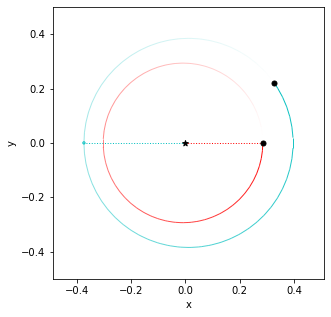

In [2]:
import rebound
rebound_sim = rebound.Simulation()
rebound_sim.add(m=1)
rebound_sim.add(m=3e-6,P = 1, e = 0.03)
rebound_sim.add(m=3e-6,P = 3 / 2, e = 0.03,l=np.pi / 5,pomega = np.pi)

rebound.OrbitPlot(rebound_sim,color=True,periastron=True);

# Initialize a ``celmech`` models directly from a `rebound.Simulation`


In [3]:
from celmech import Poincare, PoincareHamiltonian
poincare_particles = Poincare.from_Simulation(rebound_sim)
Hp = PoincareHamiltonian(poincare_particles)

# The ``PoincareHamiltonian`` class represents the system's Hamiltonian

In [4]:
type(Hp)

celmech.poincare.PoincareHamiltonian

- The ``H`` attribute stores the symbolic Hamiltonian

In [5]:
Hp.H

   2   2   3    2   2   3
  G ⋅M₂ ⋅μ₂    G ⋅M₁ ⋅μ₁ 
- ────────── - ──────────
        2            2   
    2⋅Λ₂         2⋅Λ₁    

- Keplerian terms only upon intialization 
- I.e., $H = -\frac{Gm_*m_1}{2a_1}-\frac{Gm_*m_2}{2a_2}$ when written in orbital elements

# Building a Hamiltonian
- Users build up a Hamiltonian by selecting and adding disturbing function terms
- ``PoincareHamiltonian`` includes an extensive interface for specifying and adding terms
- We'll add terms for the 3:2 MMR

In [6]:
Hp.add_MMR_terms(p=3,q=1,max_order=1,indexIn=1,indexOut=2)

# Building a Hamiltonian
- The symbolic Hamiltonian is updated with the newly-added terms

In [7]:
Hp.H

                                                               ⎛η₁⋅sin(2⋅λ₁ - 3⋅λ₂)   κ₁⋅cos(2⋅λ₁ - 3⋅λ₂)⎞          
  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜─────────────────── + ───────────────────⎟   C_{(3,-
                                                               ⎜   _______________       _______________ ⎟          
                                                               ⎝ ╲╱ \Lambda_{1,0}      ╲╱ \Lambda_{1,0}  ⎠          
- ──────────────────────────────────────────────────────────────────────────────────────────────────────── - ───────
                                                  a_{2,0}                                                           
                                                                                                                    

                                                      ⎛η₂⋅sin(2⋅λ₁ - 3⋅λ₂)   κ₂⋅cos(2⋅λ₁ - 3⋅λ₂)⎞                   
2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜────────

# Building a Hamiltonian
- Equivalent in terms of orbital elements:

In [8]:
Hp.df

<IPython.core.display.Math object>

# Integrating Hamilton's equations
 - Equations of motion automatically generated from the Hamiltonian
 - Integration and particle interface designed to mirror ``rebound``

In [9]:
rebound_particles = rebound_sim.particles
celmech_particles = Hp.particles

# times to save output
times = np.linspace(0,2500 * rebound_particles[1].P,100)

# Arrays to store results
theta_rebound = np.zeros(100)
theta_celmech = np.zeros(100)

# Main integration loop
for i,t in enumerate(times):
    # advance simulations
    rebound_sim.integrate(t)
    Hp.integrate(t)
    # save resonant angle 
    theta_celmech[i] = 3 * celmech_particles[2].l - 2 * celmech_particles[1].l - celmech_particles[1].pomega
    theta_rebound[i] = 3 * rebound_particles[2].l - 2 * rebound_particles[1].l - rebound_particles[1].pomega



# Comparing $N$-body and ``celmech``
- Plot the values of the resonant angle 
    $$\theta_\mathrm{res,1} = 3\lambda_2 - 2\lambda_1 - \varpi_1$$
    recorded from the integrations

In [10]:
wrap2pi = lambda x: 180 * (np.mod(x+np.pi,2*np.pi)-np.pi)/np.pi
theta_celmech = wrap2pi(theta_celmech)
theta_rebound = wrap2pi(theta_rebound)

(-180.0, 180.0)

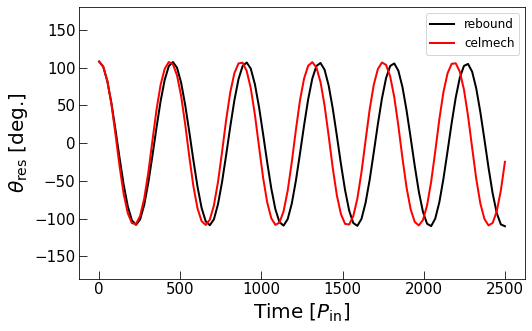

In [11]:
fig,ax = plt.subplots(1,sharex=True,figsize=(8,5))
plt.tick_params(labelsize=15,direction='in',size=8)
ax.plot(times,theta_rebound,color='k',lw=2,label='rebound')
ax.plot(times,theta_celmech,color='r',lw=2,label='celmech')
ax.set_ylabel(r"$\theta_\mathrm{res}$ [deg.]",fontsize=20)
ax.legend(fontsize=12)
ax.set_xlabel(r"Time [$P_\mathrm{in}$]",fontsize=20);
ax.set_ylim(-180,180)

## But wait, there's more!
 - **Canonical transformations**
     - Automate many common transformations
     - Lie-series transformations
 - **Secular theory**
     - Laplace-Lagrange theory (including 2nd order in mass)
     - Non-linear secular equations
         - Symplectic integration
         - Second order in mass
 - **Mean motion resonance**
     - Transform to "Andoyer" Hamiltonian
     - Numerically-averaged resonance equations
         - No expansion in $e$ and $I$
         - Supports dissipative forces
 - And **more**! (resonant chains, TTVs, frequency analysis, AMD,...)

# The ``Poincare`` class represents the system's dynamical state
- The `Poincare` class uses canonical action-angle variable pairs:
 $$\begin{align}
 \Lambda_i&= \mu_i\sqrt{GM_ia_i} ~;~ \lambda_i \\
 (\eta_i,\kappa_i)&\approx \sqrt{\Lambda_i}e_i \times(-\sin\varpi_i,\cos\varpi_i)\\
  (\rho_i,\sigma_i)&\approx \sqrt{\Lambda_i}\sin(I_i/2) \times(-\sin\Omega_i,\cos\Omega_i)\\
 \end{align}$$

In [12]:
type(poincare_particles)

celmech.poincare.Poincare

In [13]:
# Canonical coordinate-momentum pairs of system
qp_pairs = poincare_particles.qp_pairs
qp_pairs

[(λ₁, Λ₁), (η₁, κ₁), (ρ₁, σ₁), (λ₂, Λ₂), (η₂, κ₂), (ρ₂, σ₂)]

# The ``Poincare`` class represents the system's dynamical state
- Stores numerical values of canonical variables

In [14]:
Lambda1 = qp_pairs[0][1]
Lambda1, poincare_particles.qp[Lambda1]

(Λ₁, 1.626297627682381e-06)

- Also provides orbital mass, orbital elements, etc.

In [15]:
G = poincare_particles.G
particle = poincare_particles.particles[1]
particle.mu * np.sqrt(G * particle.M * particle.a)

1.6262976276823807e-06